![background](https://www.icphm.org/qfy-content/uploads/2024/03/7fce3be55122c6a17af3732565bff076.jpg.v3cache.1360.jpg)

# Exploratory Data Analysis

The [2024 Global Reliability & Prognostics and Health Management (GlobalRel&PHM) Conference](https://www.icphm.org/), co-sponsored by IEEE Reliability Society, also organized a [data challenge](https://www.icphm.org/?page_id=9110) on fault diagnosis in train railway systems. This IEEE PHM Beijing Data Challenge 2024 aims to improve the fault detection to prevent accidents and irreparable components in railway systems. 

### Task
The task is time series multiclass classification. Given 21 time series sensor signals for a sample, identify its type of fault (17 types) or combination of faults. Each time series data in the training dataset is a 10-second sensor reading at 64kHz, giving us 640000 datapoints per time series. On the otherhand, the test dataset only includes 1-second sensor readings. The organizers mentioned that the data came from their experimental platform simulation of subway train bogie. Since this is a simulation dataset,  there seems to be no missing data at all. 

### Added Difficulty
To add more difficulty into the competition, the organizers did not provide the specific working condition of each sample and that the working conditions in the training dataset are different from that of the test dataset. They said that there are 9 working conditions pertaining to the motor speed (kHz) and the lateral load (kN). Also, the organizers did not specify the actual measuring devices and their measurement uncertainty ranges.

## Import Relevant Libraries

In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import os

In [20]:
TRAIN_DIR = "/kaggle/input/ieee-phm-data-challenge-beijing-2024/Data_Pre Stage/Data_Pre Stage/Training data/Training data"
TEST_DIR = "/kaggle/input/ieee-phm-data-challenge-beijing-2024/Data_Pre Stage/Data_Pre Stage/Test data/Test data"

## Target Labels

During the preliminary stage, the competition organizers revealed 17 labels (1 normal and 16 single fault labels) for each sample. The number of labels might increase during the final stage which will begin on June 01, 2024. Furthermore, they will introduce compound labels for each sample which will increase the difficulty. For example, Sample 298 may have 3 fault types such as TYPE 1, TYPE 3, and TYPE 8. The single fault types and their descriptions are summarized in the table below:

| Fault Code | Motor | Gearbox | Axlebox | Description |
|-|-|-|-|-|
| TYPE 0 | M0 | G0 | LA0 | All components in normal condition |
| TYPE 1 | **M1** | G0 | LA0 | Motor - short circuit |
| TYPE 2 | **M2** | G0 | LA0 | Motor - broken rotor bar |
| TYPE 3 | **M3** | G0 | LA0 | Motor - bearing fault |
| TYPE 4 | **M4** | G0 | LA0 | Motor - bowed rotor |
| TYPE 5 | M0 | **G1** | LA0 | Gearbox - gear cracked tooth |
| TYPE 6 | M0 | **G2** | LA0 | Gearbox - gear worn tooth |
| TYPE 7 | M0 | **G3** | LA0 | Gearbox - gear missing tooth |
| TYPE 8 | M0 | **G4** | LA0 | Gearbox - gear chipped tooth |
| TYPE 9 | M0 | **G5** | LA0 | Gearbox - bearing inner race fault |
| TYPE 10 | M0 | **G6** | LA0 | Gearbox - bearing outer race fault |
| TYPE 11 | M0 | **G7** | LA0 | Gearbox - bearing rolling element fault |
| TYPE 12 | M0 | **G8** | LA0 | Gearbox - bearing cage fault |
| TYPE 13 | M0 | G0 | **LA1** | Axle box - bearing inner race fault |
| TYPE 14 | M0 | G0 | **LA2** | Axle box - bearing outer race fault |
| TYPE 15 | M0 | G0 | **LA3** | Axle box - bearing rolling element fault |
| TYPE 16 | M0 | G0 | **LA4** | Axle box - bearing cage fault |


<div align="center"><img src="https://fcdn.goodq.top/caches/2f873ab68ade942dfc46ef78430c4bdc/aHR0cHM6Ly93d3cuaWNwaG0ub3JnL3FmeS1jb250ZW50L3VwbG9hZHMvMjAyNC8wMi9pbWFnZTEwLnBuZy52M2NhY2hlLjYyOC5wbmc_p_p100_p_3D.png" width="1000"></div>

The figure above shows actual examples of fault types in each component (a) Motor, (b) Gearbox, (c) Axle Box.
 
#### Right axle box seems irrelevant 
It seems that the data from rightaxlebox is not relevant as the information is already captured in the leftaxlebox data. 
This is yet to be confirmed with the succeeding release of data every two weeks during the final stage.

In [21]:
# Fault codes for motor, gearbox, and axlebox

component_fault = {
"motor": ["TYPE1","TYPE2","TYPE3","TYPE4"],
"gearbox": ["TYPE5","TYPE6","TYPE7","TYPE8","TYPE9","TYPE10","TYPE11","TYPE12"],
"leftaxlebox" : ["TYPE13","TYPE14","TYPE15","TYPE16"]
}

component_channels = {
    "motor":["CH1","CH2","CH3","CH4","CH5","CH6","CH7","CH8","CH9"],
    "gearbox":["CH10","CH11","CH12","CH13","CH14","CH15"],
    "leftaxlebox":["CH16","CH17","CH18"],
    "rightaxlebox":["CH19","CH20","CH21"]
}

components = component_fault.keys()

## Channels as Features

Next, let's look at the features which are referred to in the competition as channels because they are sensor data, either vibration (accelerometer) or current (ammeter). 

| Channel | Component | Signal Type |
| - | - | - |
| CH1, CH2, CH3 | Motor (drive end) | Tri-axial acceleration |
| CH4, CH5, CH6 | Motor (fan end) | Tri-axial acceleration |
| CH7, CH8, CH9 | Motor (cable) | Three-phase current |
| CH10, CH11, CH12 | Gearbox (input axle) | Tri-axial acceleration |
| CH13, CH14, CH15 | Gearbox (output axle) | Tri-axial acceleration |
| CH16, CH17, CH18 | Axle box left (end cover) | Tri-axial acceleration |
| CH19, CH20, CH21 | Axle box right (end cover) | Tri-axial acceleration |



## Dataset

During the preliminary stage,
* Test set: 102 samples
* Train set: 3 samples for each fault type

In [22]:
!tree /kaggle/input/ieee-phm-data-challenge-beijing-2024/Data_Pre\ Stage/Data_Pre\ Stage/Training\ data/Training\ data/TYPE0/TYPE0/

/kaggle/input/ieee-phm-data-challenge-beijing-2024/Data_Pre\ Stage/Data_Pre\ Stage/Training\ data/Training\ data/TYPE0/TYPE0/
|-- Sample1
|   |-- data_gearbox.csv
|   |-- data_leftaxlebox.csv
|   |-- data_motor.csv
|   `-- data_rightaxlebox.csv
|-- Sample2
|   |-- data_gearbox.csv
|   |-- data_leftaxlebox.csv
|   |-- data_motor.csv
|   `-- data_rightaxlebox.csv
`-- Sample3
    |-- data_gearbox.csv
    |-- data_leftaxlebox.csv
    |-- data_motor.csv
    `-- data_rightaxlebox.csv

3 directories, 12 files


## Plot Data on LA4 vs. ~LA4


In [47]:
faulty_type = "TYPE16"

CH16 | fault type:TYPE16 | Sample 1


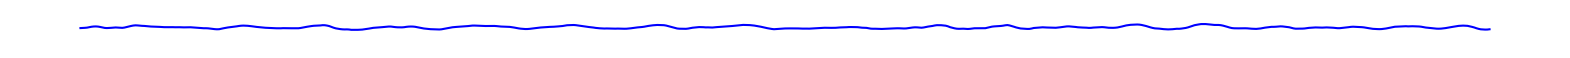

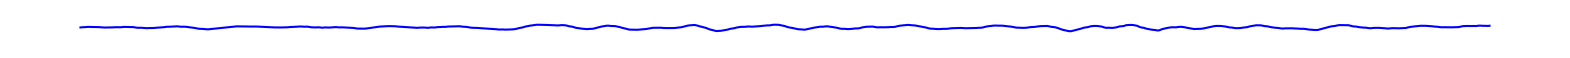

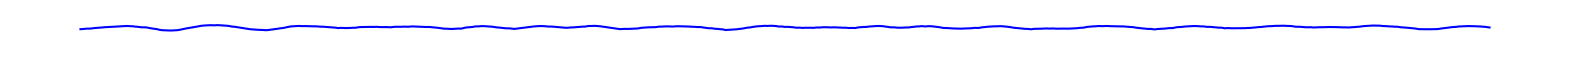

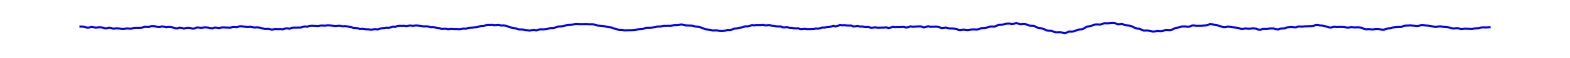

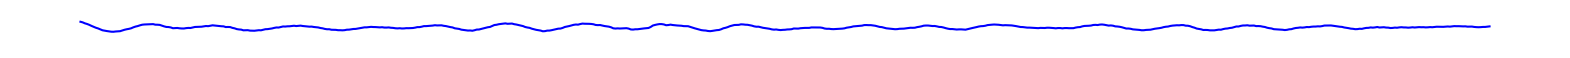

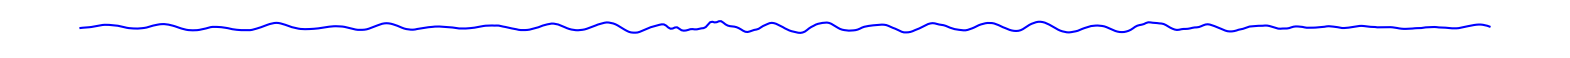

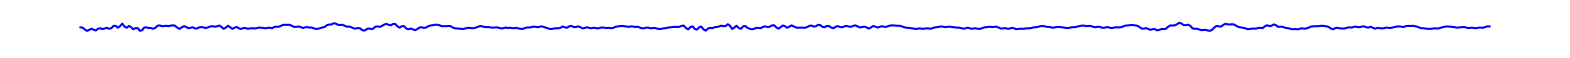

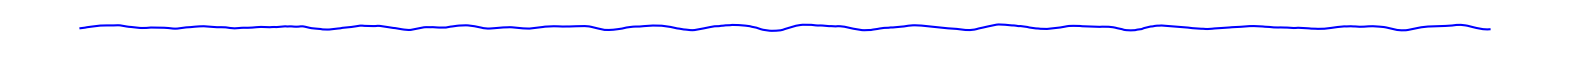

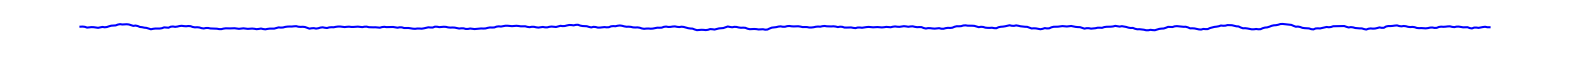

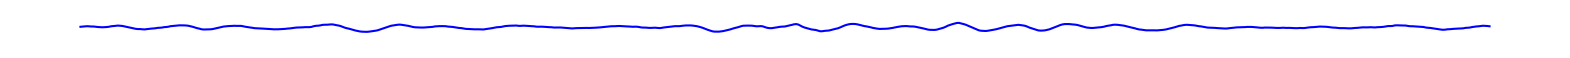

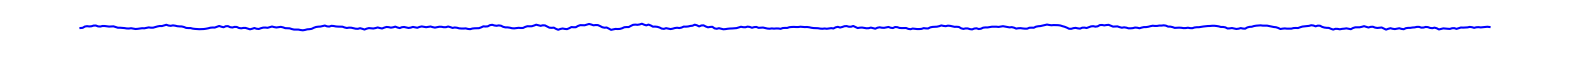

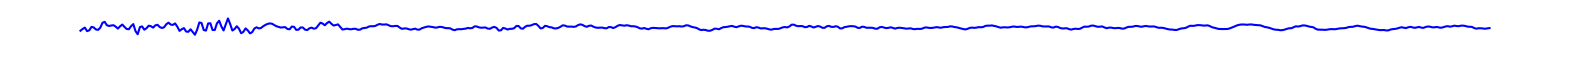

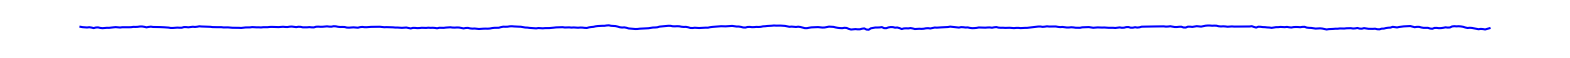

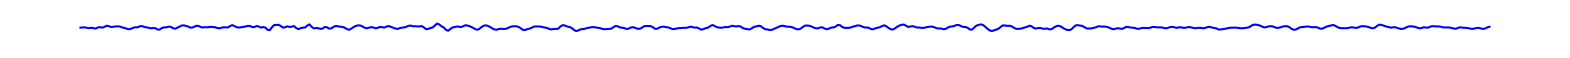

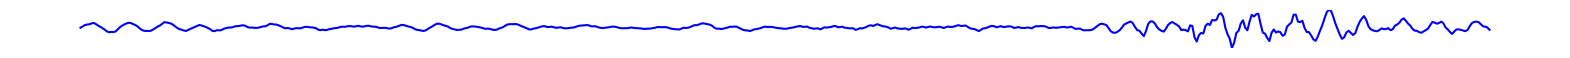

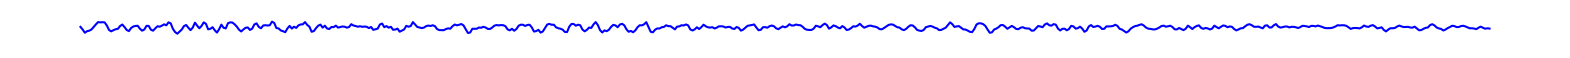

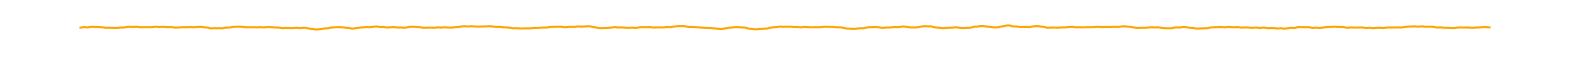

CH17 | fault type:TYPE16 | Sample 1


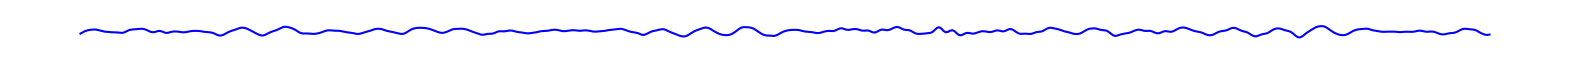

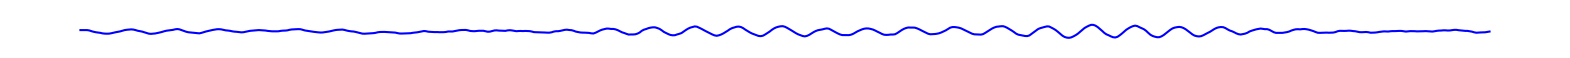

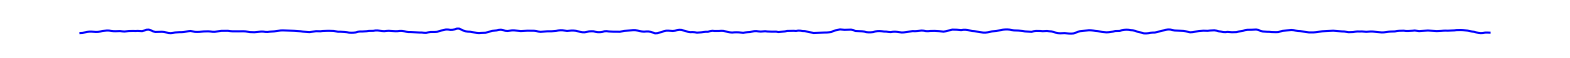

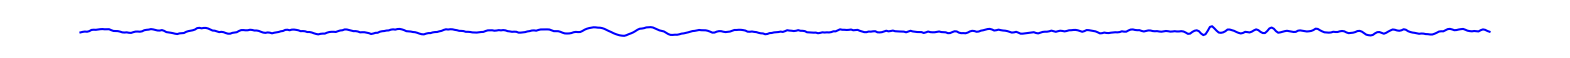

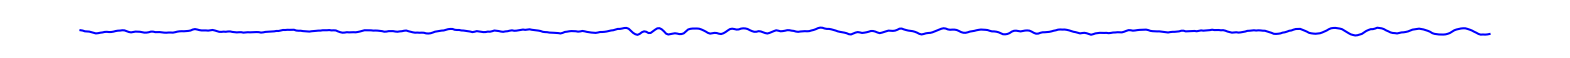

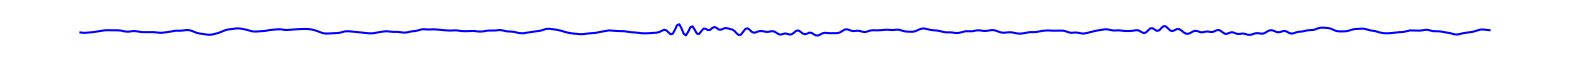

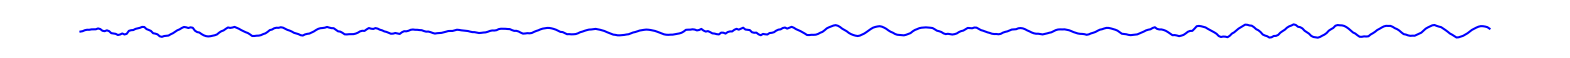

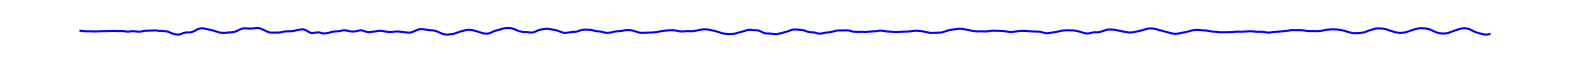

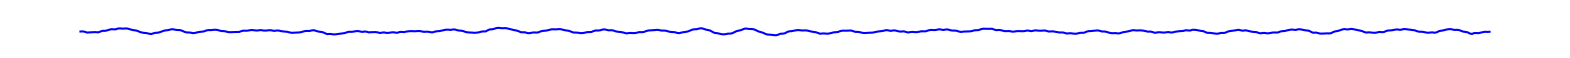

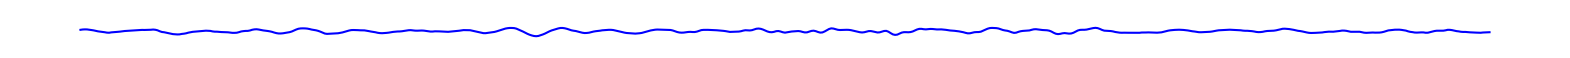

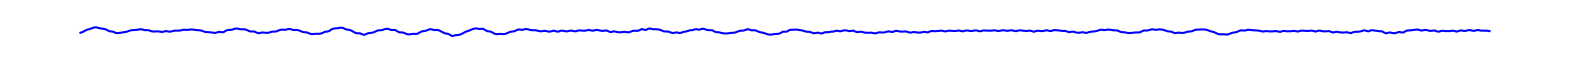

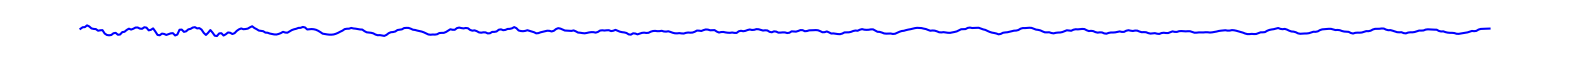

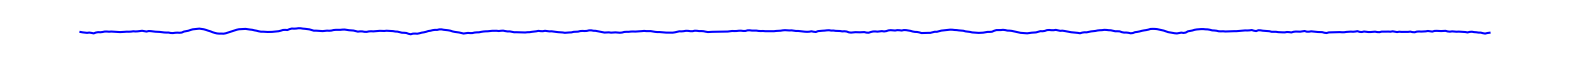

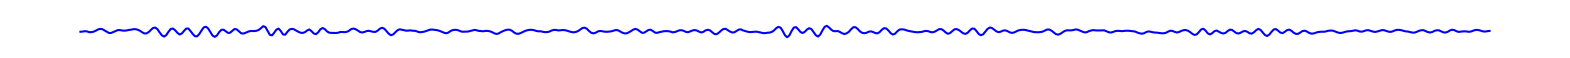

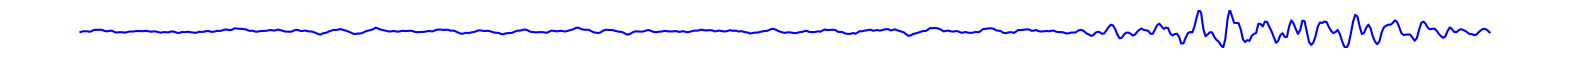

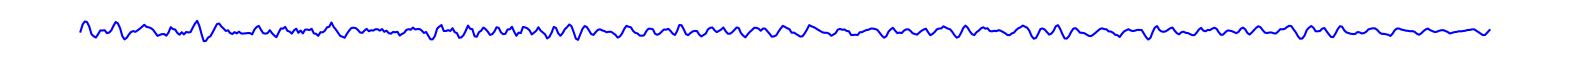

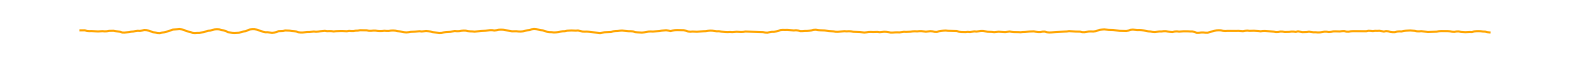

CH18 | fault type:TYPE16 | Sample 1


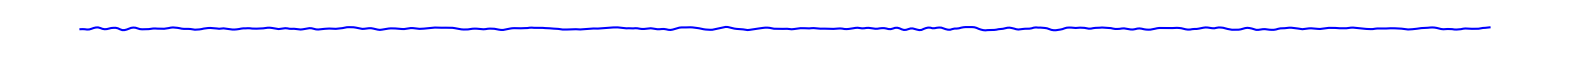

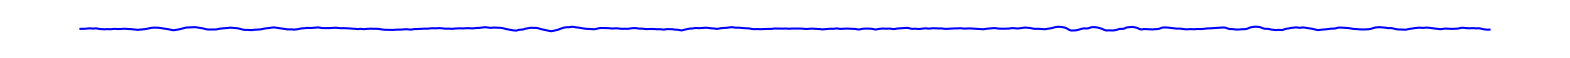

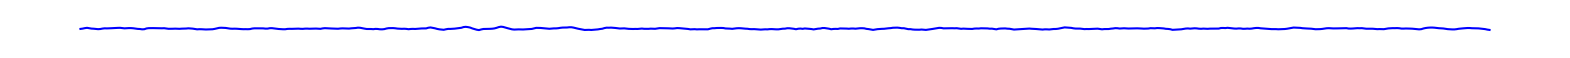

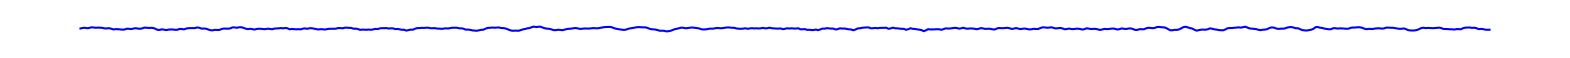

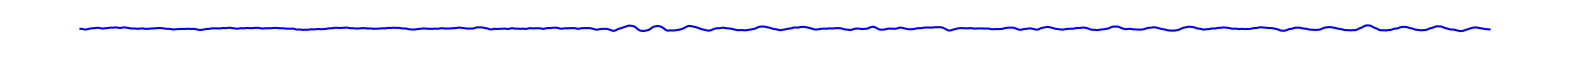

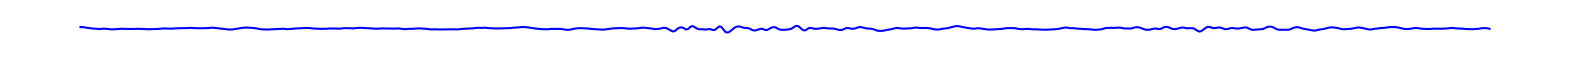

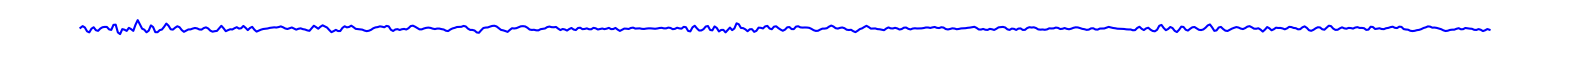

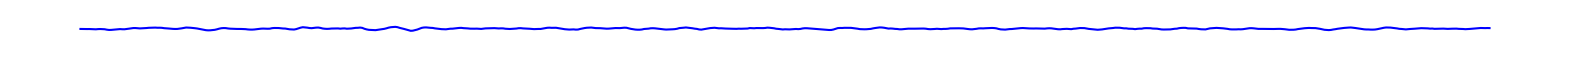

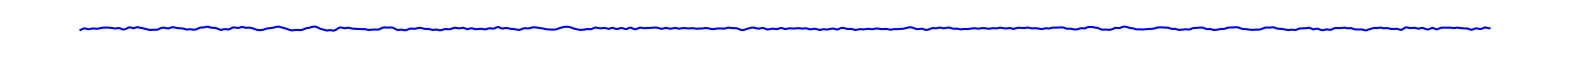

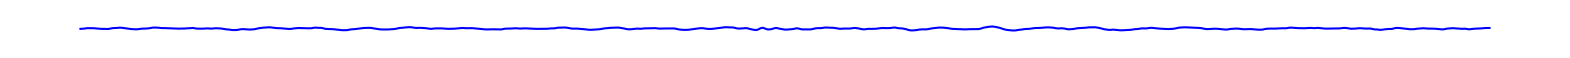

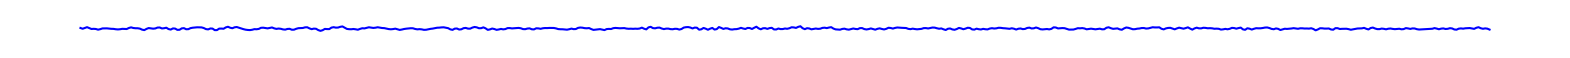

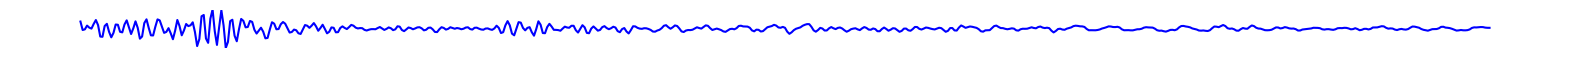

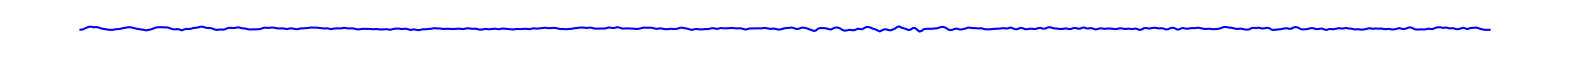

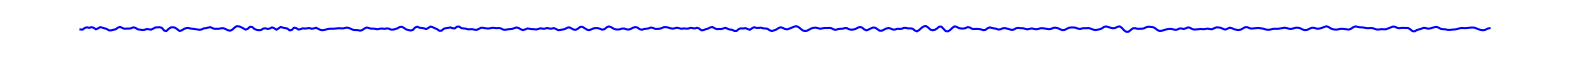

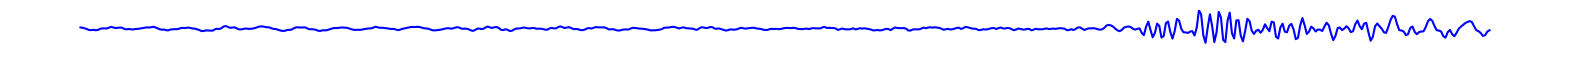

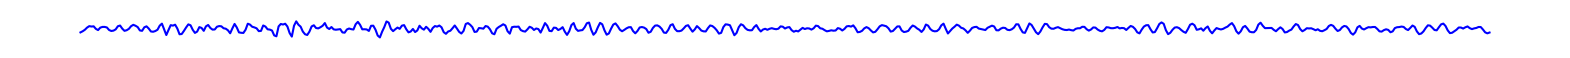

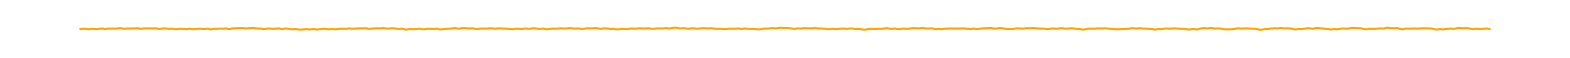

In [48]:
freq = 20
datapoints = 640

for component in list(component_fault.keys()):
    if faulty_type in component_fault[component]:
        break

for channel in component_channels[component]:
    print(f"{channel} | fault type:{faulty_type} | Sample 1")
    
    if channel in ("CH7","CH8","CH9"):
        datapoints = 64000
    
    ymin = 0
    ymax = 0
    for fault_num in range(0,17):
        fault_type = "TYPE" + str(fault_num)

        data_df = pd.read_csv(f"{TRAIN_DIR}/{fault_type}/{fault_type}/Sample1/data_{component}.csv")
        max_y = data_df.loc[:datapoints, channel].max()
        min_y = data_df.loc[:datapoints, channel].min()
        if max_y > ymax:
            ymax = max_y
        if min_y < ymin:
            ymin = min_y
    
    for fault_num in range(0,17):
        fault_type = "TYPE" + str(fault_num)

        data_df = pd.read_csv(f"{TRAIN_DIR}/{fault_type}/{fault_type}/Sample1/data_{component}.csv")
        max_amp = data_df[channel].max()
        time = np.linspace(0,datapoints,datapoints)
        sinusoid = max_amp/2*np.sin(2*np.pi*time*freq*2)

        color = "blue"
        label = "normal"
        if fault_type == faulty_type:
            color = "orange"
            label = "anomaly"

        #print(fault_type, label)

        # Plot parallel coordinates
        plt.figure(figsize=(20, 0.5))
        plt.plot(data_df.loc[:datapoints, channel], color=color, label=f'{label}')
        #plt.plot(sinusoid, color='red')
        plt.ylim(ymin,ymax)
        plt.axis('off')
        plt.show()

CH16 | fault type:TYPE16 | Sample 2


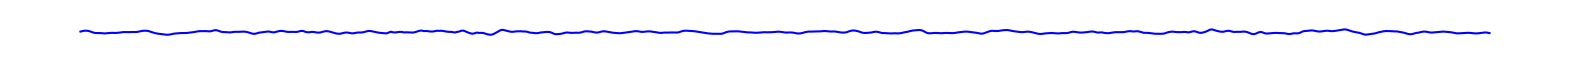

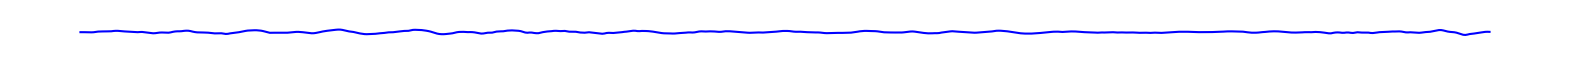

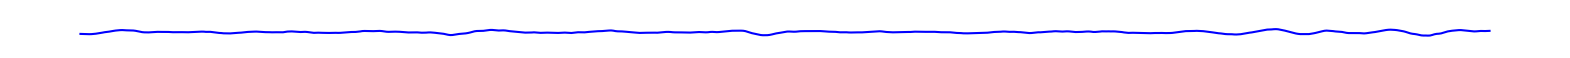

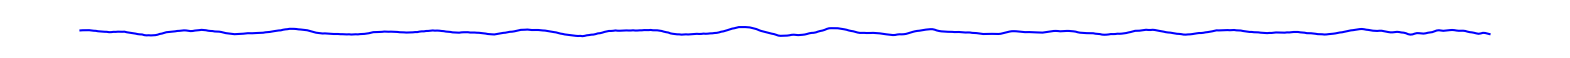

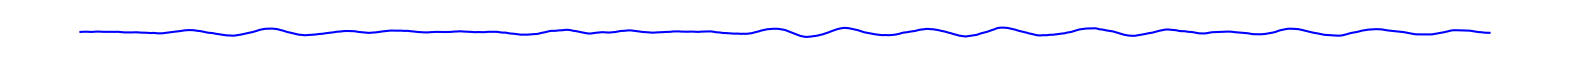

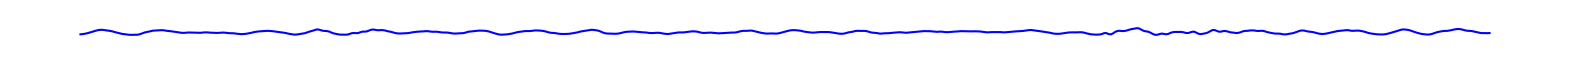

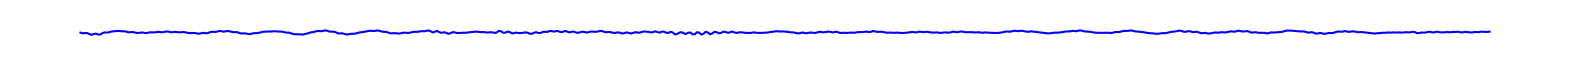

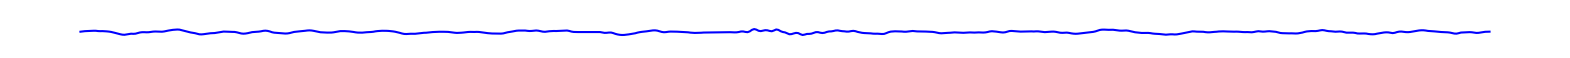

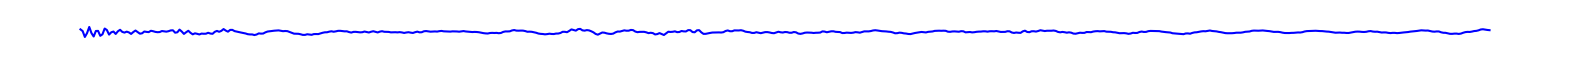

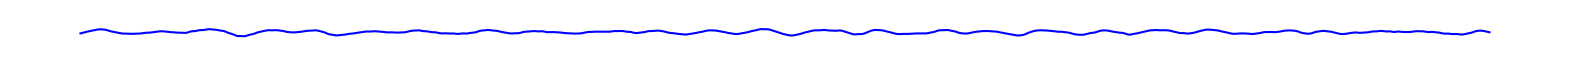

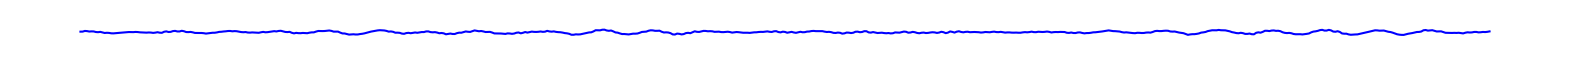

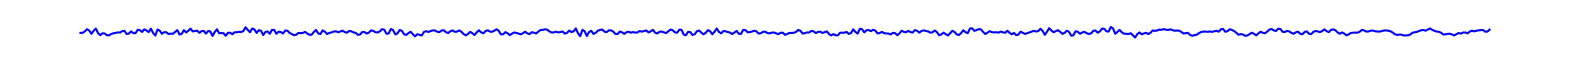

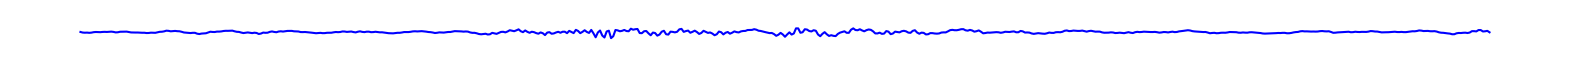

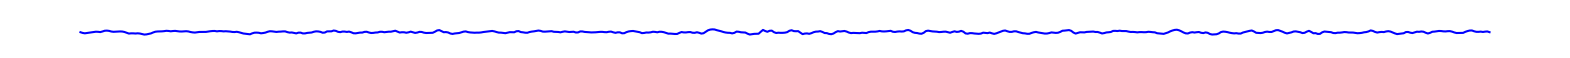

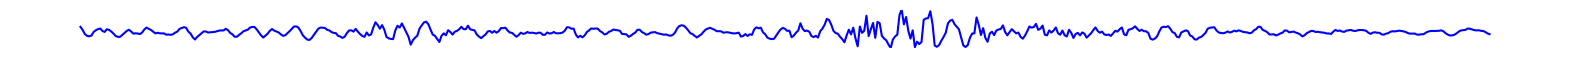

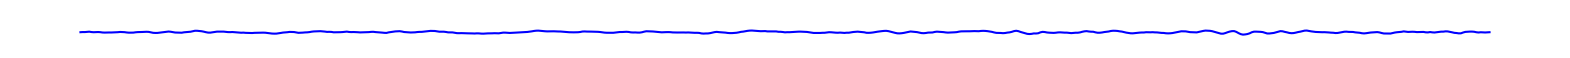

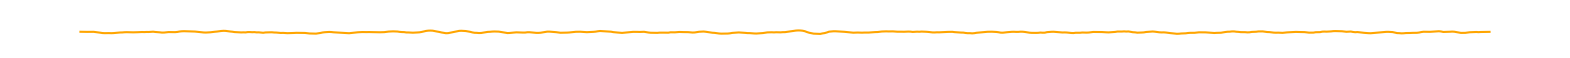

CH17 | fault type:TYPE16 | Sample 2


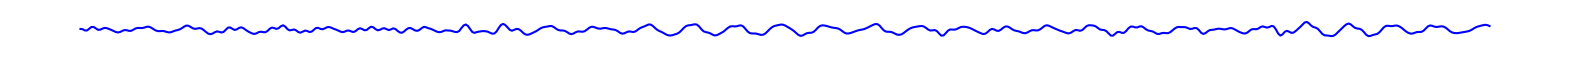

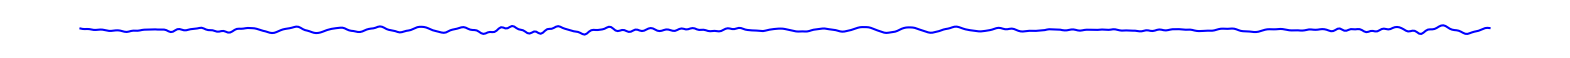

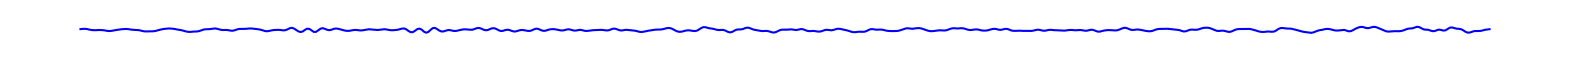

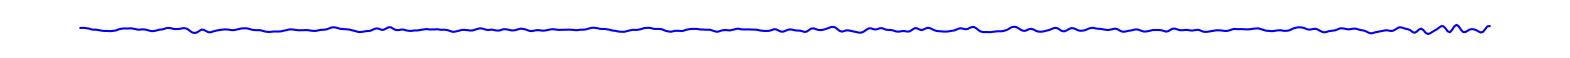

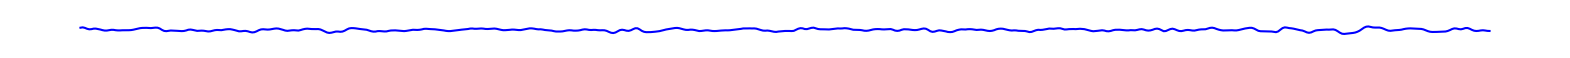

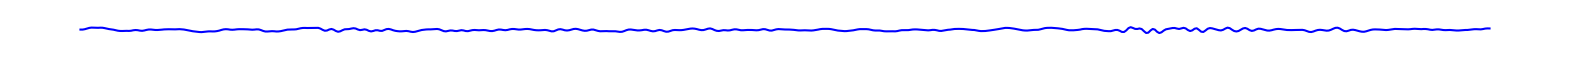

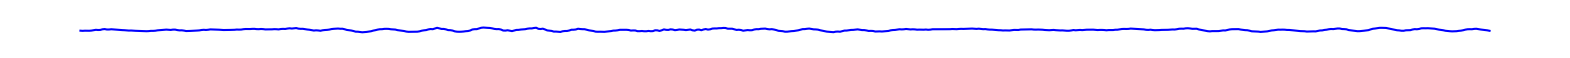

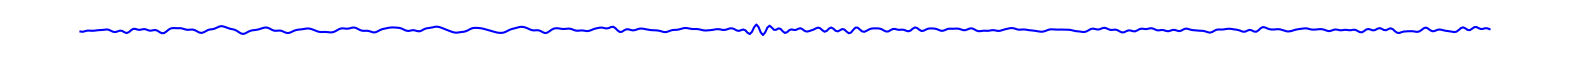

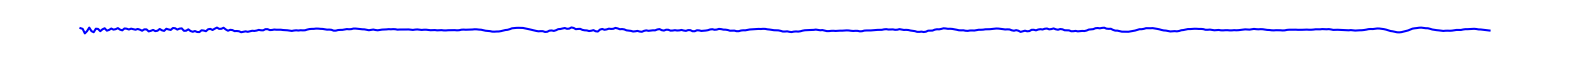

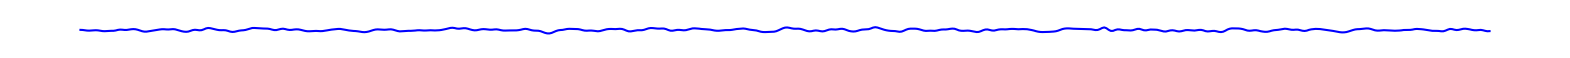

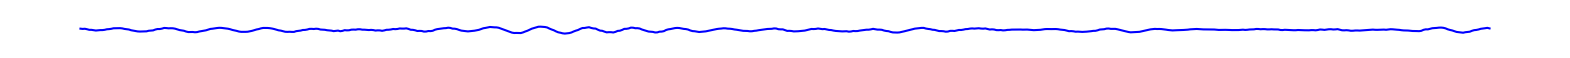

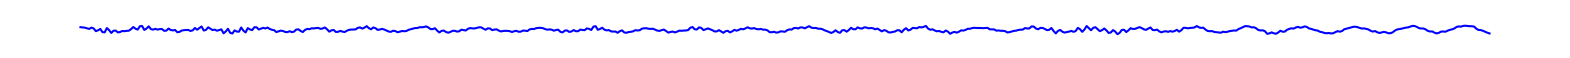

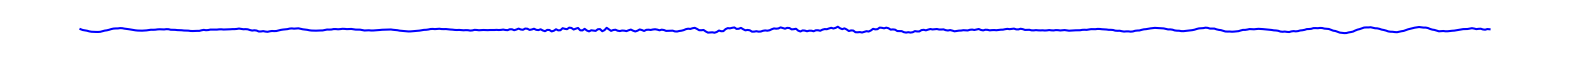

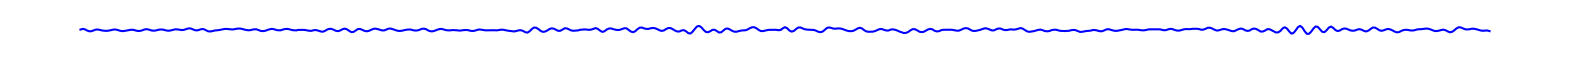

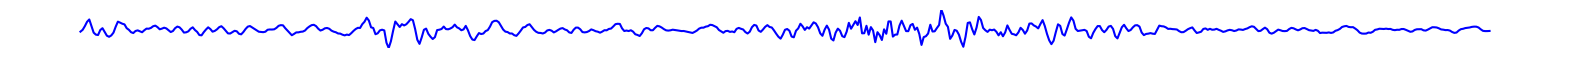

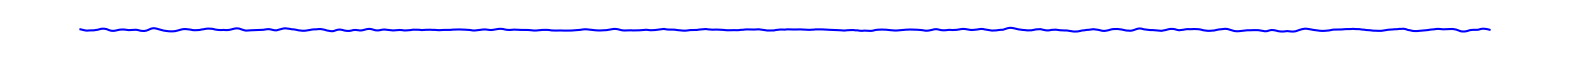

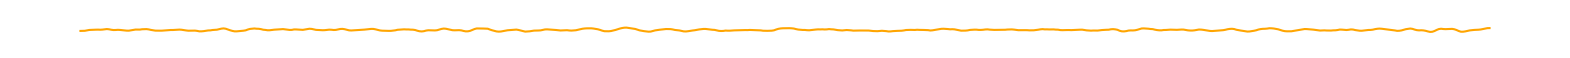

CH18 | fault type:TYPE16 | Sample 2


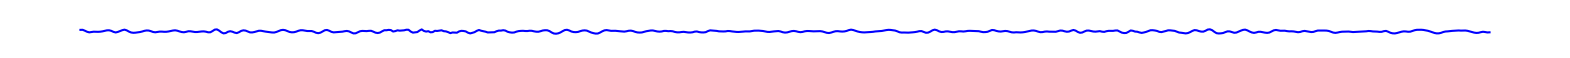

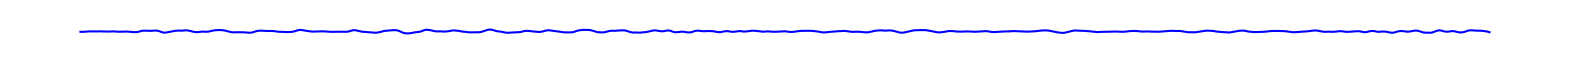

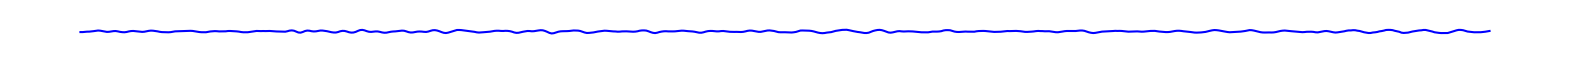

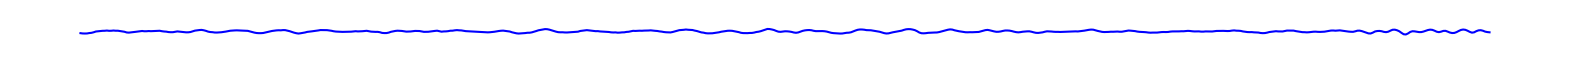

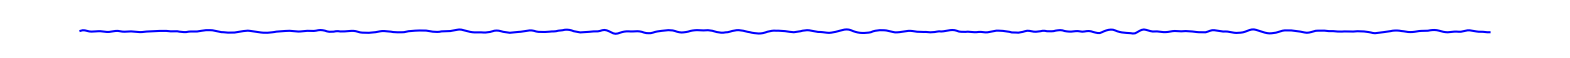

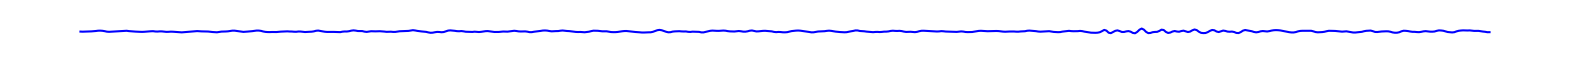

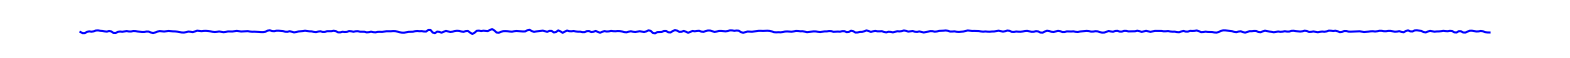

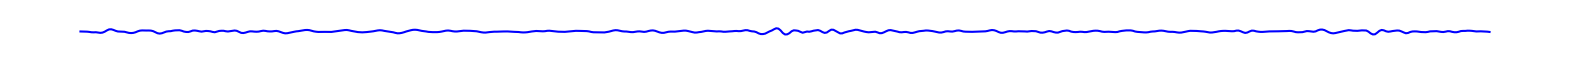

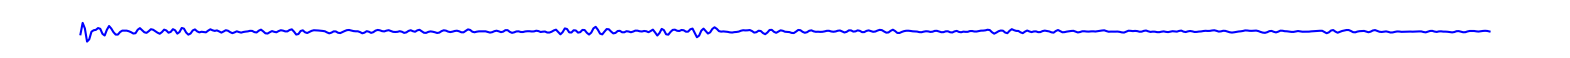

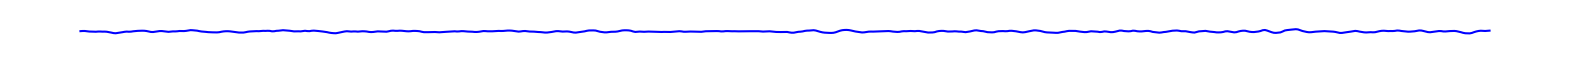

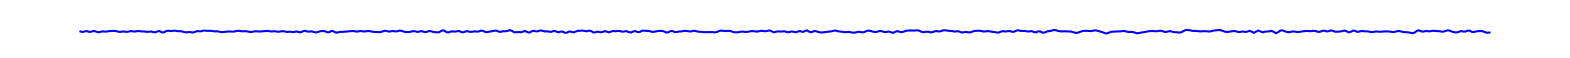

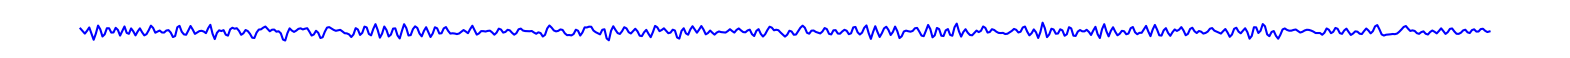

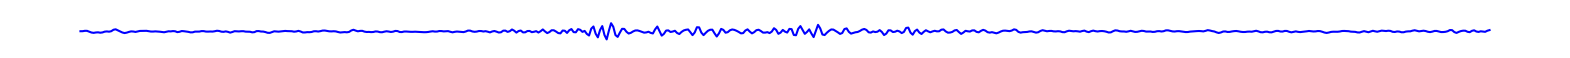

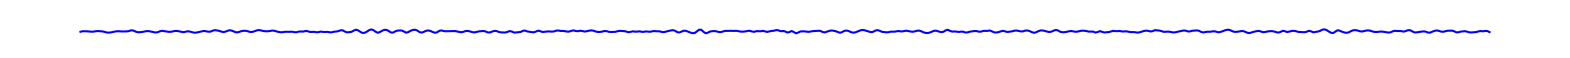

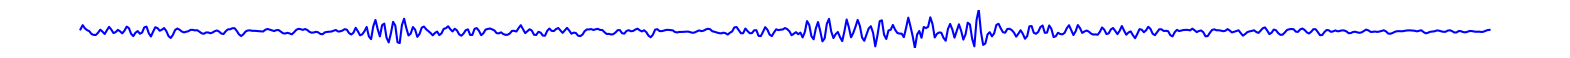

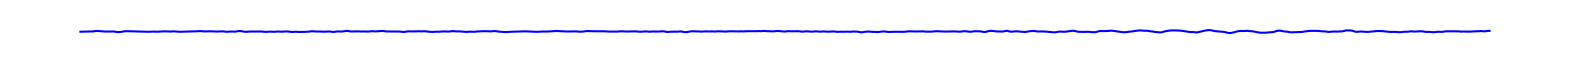

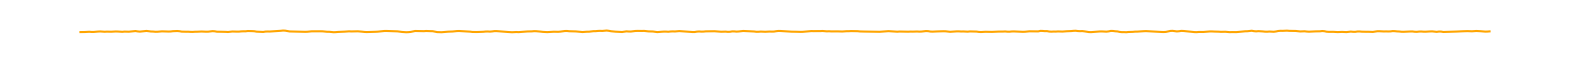

In [49]:

freq = 20
datapoints = 640

for channel in component_channels[component]:
    print(f"{channel} | fault type:{faulty_type} | Sample 2")
    
    if channel in ("CH7","CH8","CH9"):
        datapoints = 64000
    
    ymin = 0
    ymax = 0
    for fault_num in range(0,17):
        fault_type = "TYPE" + str(fault_num)

        data_df = pd.read_csv(f"{TRAIN_DIR}/{fault_type}/{fault_type}/Sample2/data_{component}.csv")
        max_y = data_df.loc[:datapoints, channel].max()
        min_y = data_df.loc[:datapoints, channel].min()
        if max_y > ymax:
            ymax = max_y
        if min_y < ymin:
            ymin = min_y
    
    for fault_num in range(0,17):
        fault_type = "TYPE" + str(fault_num)

        data_df = pd.read_csv(f"{TRAIN_DIR}/{fault_type}/{fault_type}/Sample2/data_{component}.csv")
        max_amp = data_df[channel].max()
        time = np.linspace(0,datapoints,datapoints)
        sinusoid = max_amp/2*np.sin(2*np.pi*time*freq*2)

        color = "blue"
        label = "normal"
        if fault_type == faulty_type:
            color = "orange"
            label = "anomaly"

        #print(fault_type, label)

        # Plot parallel coordinates
        plt.figure(figsize=(20, 0.5))
        plt.plot(data_df.loc[:datapoints, channel], color=color, label=f'{label}')
        #plt.plot(sinusoid, color='red')
        plt.ylim(ymin,ymax)
        plt.axis('off')
        plt.show()

CH16 | fault type:TYPE16 | Sample 3


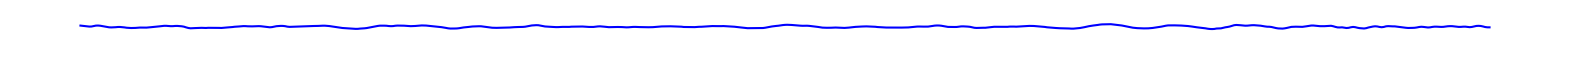

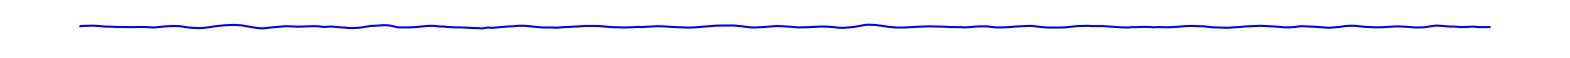

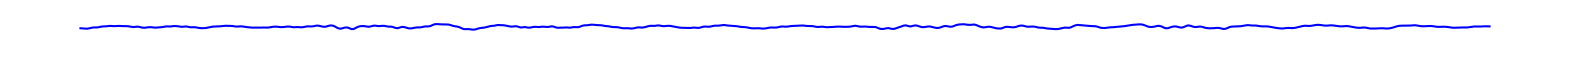

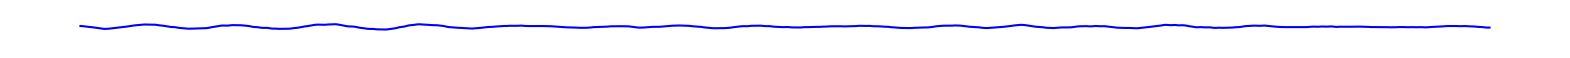

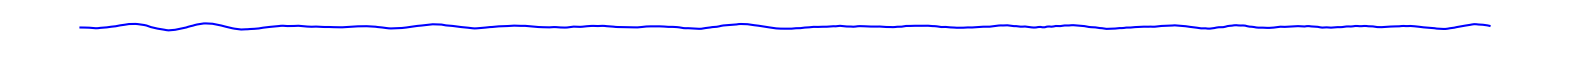

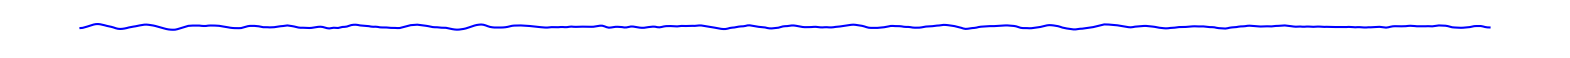

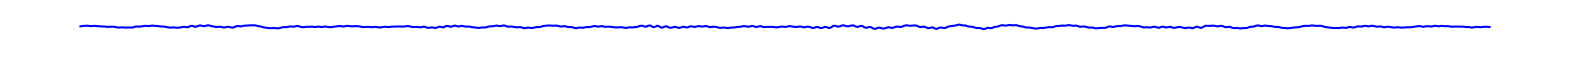

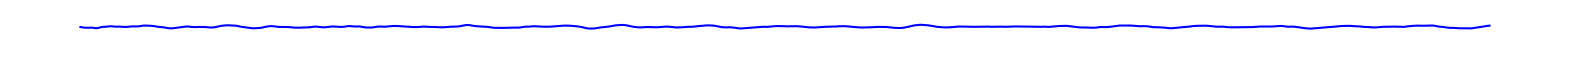

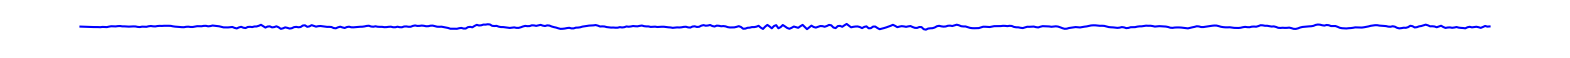

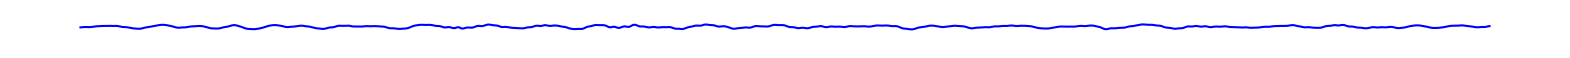

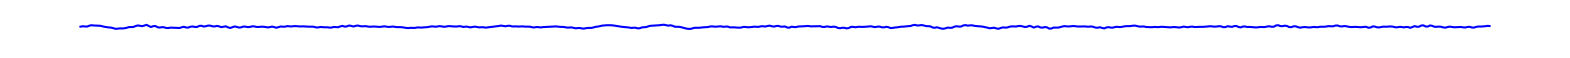

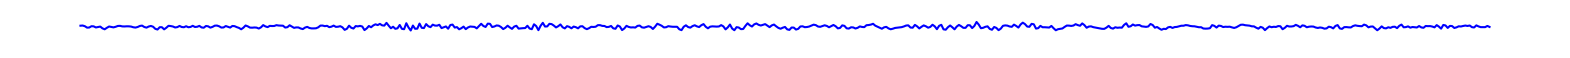

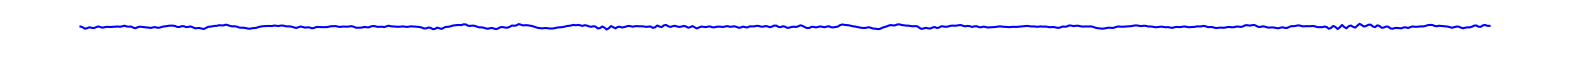

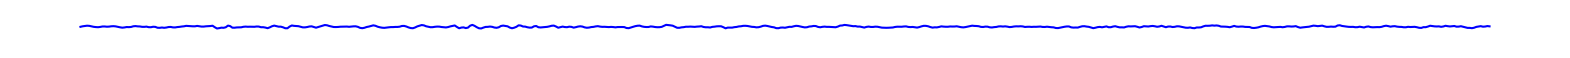

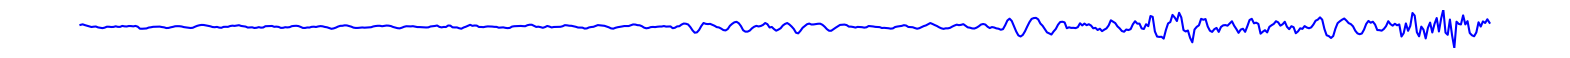

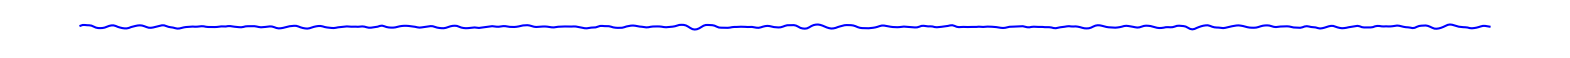

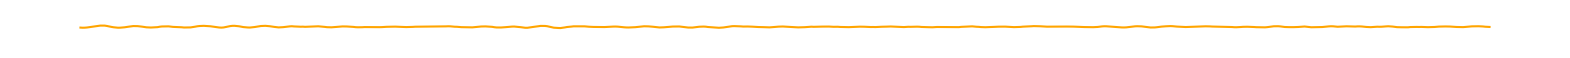

CH17 | fault type:TYPE16 | Sample 3


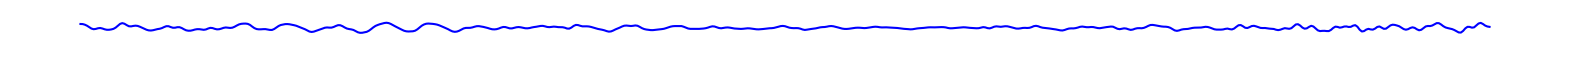

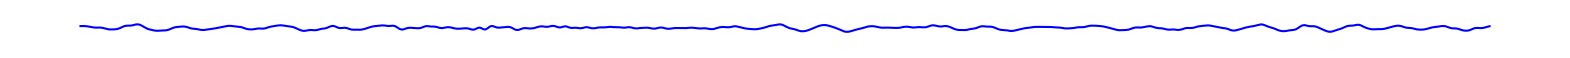

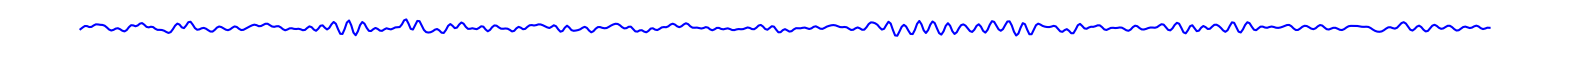

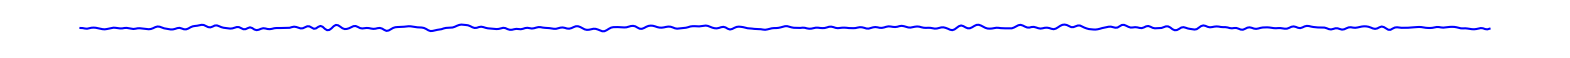

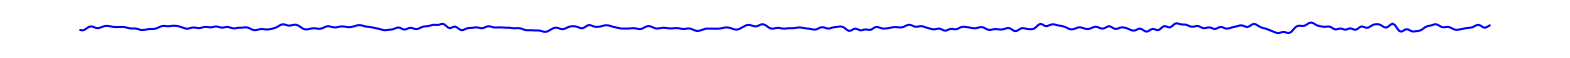

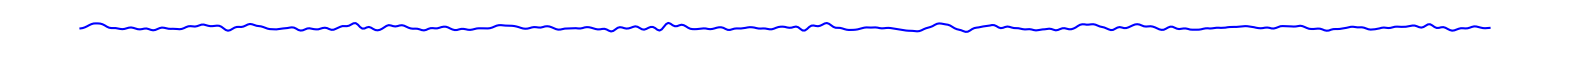

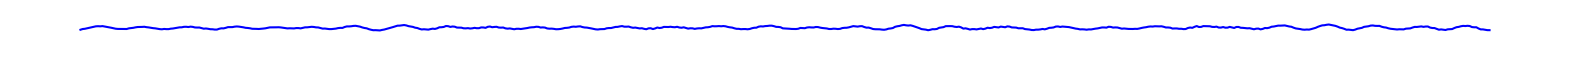

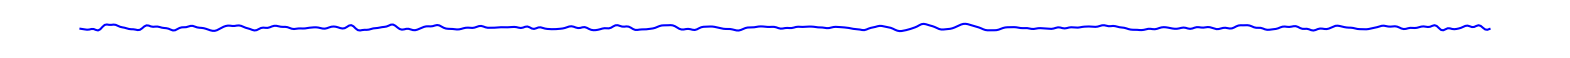

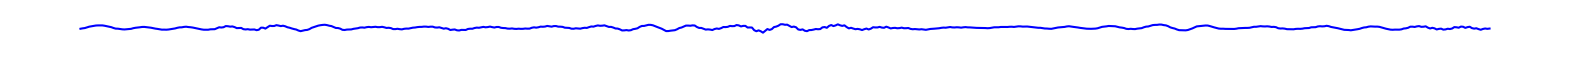

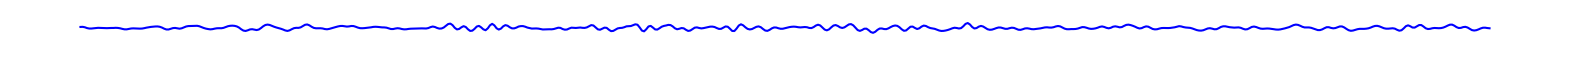

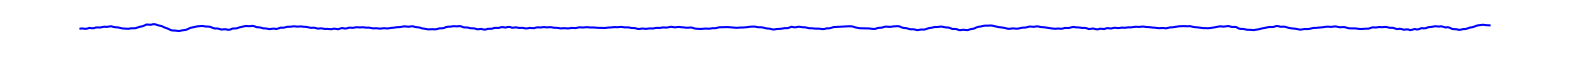

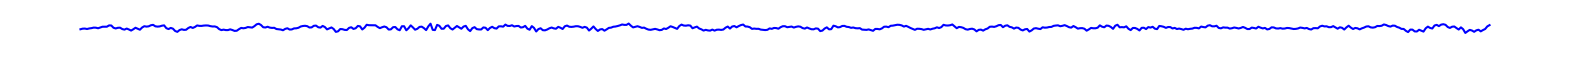

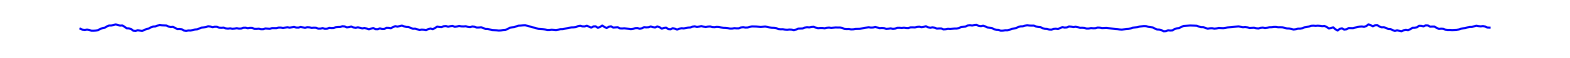

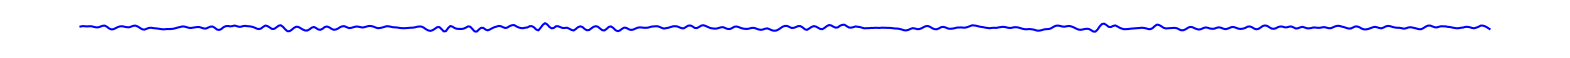

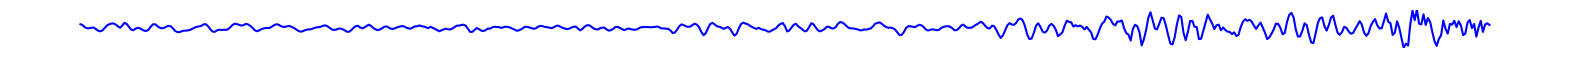

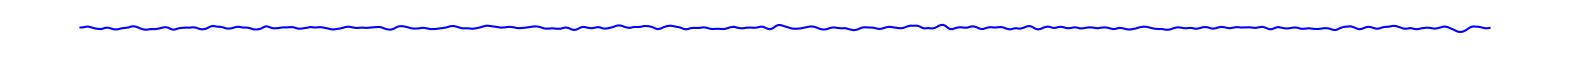

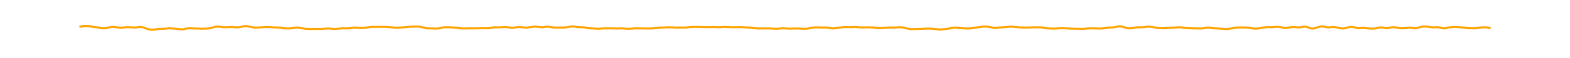

CH18 | fault type:TYPE16 | Sample 3


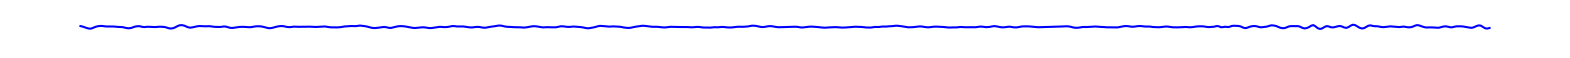

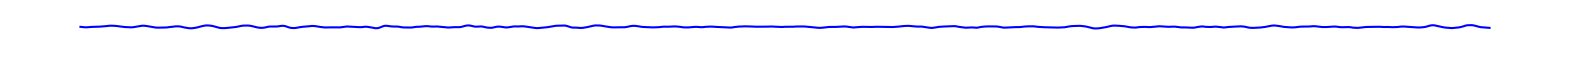

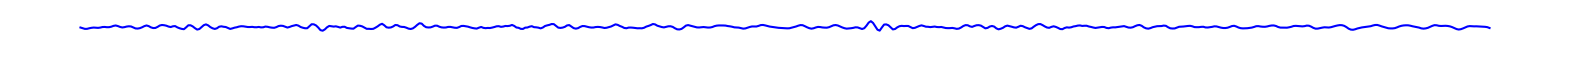

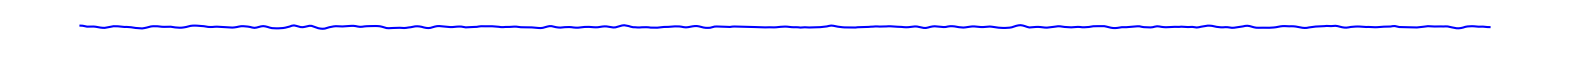

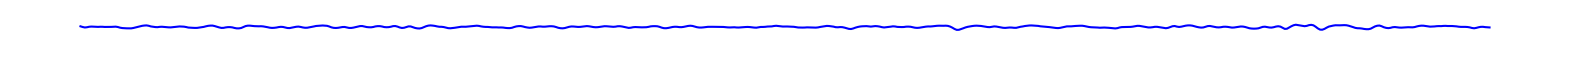

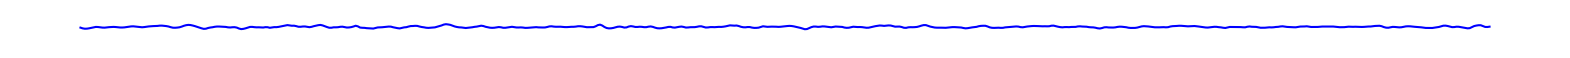

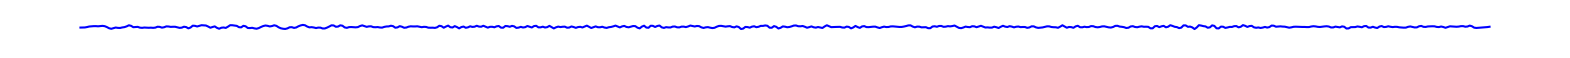

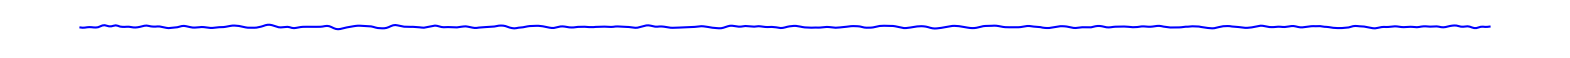

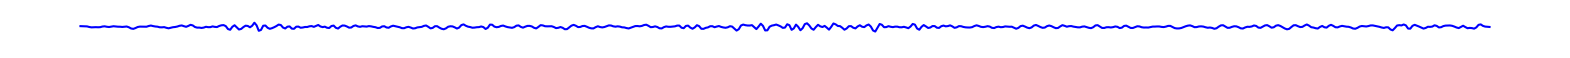

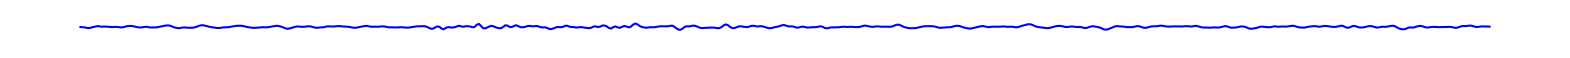

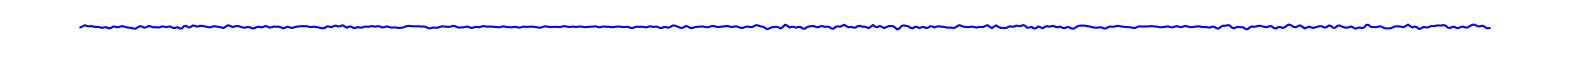

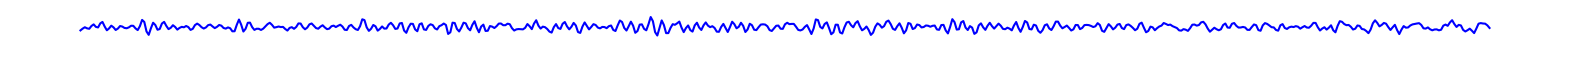

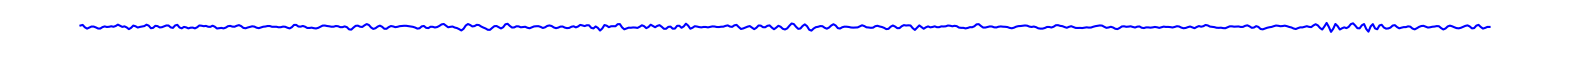

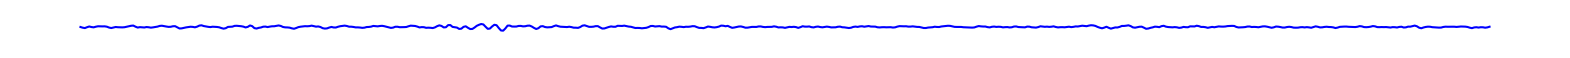

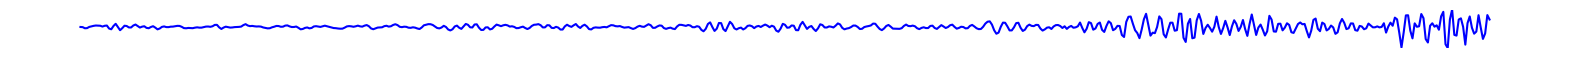

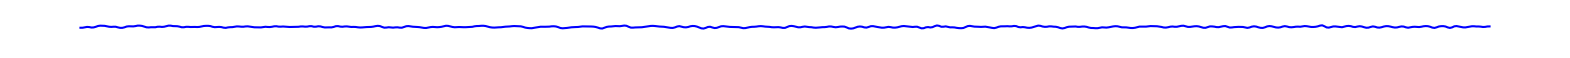

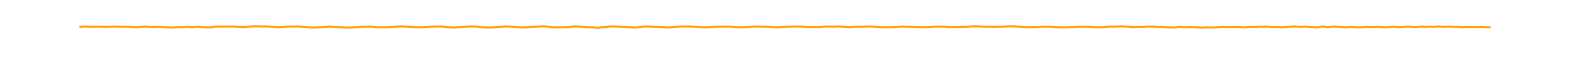

In [50]:
freq = 20
datapoints = 640

for channel in component_channels[component]:
    print(f"{channel} | fault type:{faulty_type} | Sample 3")
    
    if channel in ("CH7","CH8","CH9"):
        datapoints = 64000
    
    ymin = 0
    ymax = 0
    for fault_num in range(0,17):
        fault_type = "TYPE" + str(fault_num)

        data_df = pd.read_csv(f"{TRAIN_DIR}/{fault_type}/{fault_type}/Sample3/data_{component}.csv")
        max_y = data_df.loc[:datapoints, channel].max()
        min_y = data_df.loc[:datapoints, channel].min()
        if max_y > ymax:
            ymax = max_y
        if min_y < ymin:
            ymin = min_y
    
    for fault_num in range(0,17):
        fault_type = "TYPE" + str(fault_num)

        data_df = pd.read_csv(f"{TRAIN_DIR}/{fault_type}/{fault_type}/Sample3/data_{component}.csv")
        max_amp = data_df[channel].max()
        time = np.linspace(0,datapoints,datapoints)
        sinusoid = max_amp/2*np.sin(2*np.pi*time*freq*2)

        color = "blue"
        label = "normal"
        if fault_type == faulty_type:
            color = "orange"
            label = "anomaly"

        #print(fault_type, label)

        # Plot parallel coordinates
        plt.figure(figsize=(20, 0.5))
        plt.plot(data_df.loc[:datapoints, channel], color=color, label=f'{label}')
        #plt.plot(sinusoid, color='red')
        plt.ylim(ymin,ymax)
        plt.axis('off')
        plt.show()

## Observation

* No obvious channels to use.

## References

* [PHM-Beijing 2024](https://www.icphm.org/?page_id=9110)
* [Ding, Ao, et al. "Evolvable graph neural network for system-level incremental fault diagnosis of train transmission systems." Mechanical Systems and Signal Processing 210 (2024): 111175.](https://www.sciencedirect.com/science/article/pii/S0888327024000736)